<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/Work_in_progress/Wrapped_up_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports for SKLearn Classification(can be skipped)

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings("ignore")

# Imports

In [268]:
!pip install torchmetrics --quiet
!pip install -U scikit-learn --user --quiet
!pip install autorank --quiet



In [269]:
# libary imports 
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import pandas as pd
import itertools
from functools import reduce
import operator
import inspect
from tqdm.notebook import trange, tqdm
from pandas.io.sql import PandasSQL
from numpy.random import randint
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data as data_utils
from torch.utils.data import Subset
import torchvision
import torchvision.datasets as datasets
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.adadelta import Adadelta
from torch.optim.adagrad import Adagrad
from torch.optim.adam import Adam
from torch.optim.adamax import Adamax
from torch.optim.adamw import AdamW
from torch.optim.optimizer import Optimizer
from torch.optim.sgd import SGD
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import label_binarize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import average_precision_score,auc,PrecisionRecallDisplay
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,precision_recall_curve
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from hyperopt import hp
import warnings
from autorank import autorank, plot_stats, create_report, latex_table
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [5, 5]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Main program

# Helper  functions

In [320]:
def get_classification_report(y, y_pred):
       # y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
       # y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()   
        print(classification_report(y, y_pred))



def get_confusion_matrix(y, y_pred, plot=True):    
       
    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(20,5))
        sns.heatmap(cm, ax=axs[0],annot=True, fmt='.2f', xticklabels=np.arange(len(torch.unique(torch.tensor(y_pred)))),
                    yticklabels=np.arange(len(torch.unique(torch.tensor(y_pred)))))
        axs[0].set_ylabel('Actual')
        axs[0].set_xlabel('Predicted')
        axs[0].set_title('CM')
        sns.heatmap(cmn, ax=axs[1] ,annot=True, fmt='.2f', xticklabels=np.arange(len(torch.unique(torch.tensor(y_pred)))),
                    yticklabels=np.arange(len(torch.unique(torch.tensor(y_pred)))))
        axs[1].set_ylabel('Actual')
        axs[1].set_xlabel('Predicted')
        axs[1].set_title('NCM')
        plt.show(block=False)
    return cm

def get_curves(y, y_pred,y_pred_score):
    n_classes=n_classes=len(np.unique(y))

    lw=2
    if n_classes==2:
      roc_auc = roc_auc_score(y, y_pred_score)
      fpr, tpr, thresh=roc_curve(y, y_pred_score)
      auc=metrics.auc(fpr, tpr)
      
      # Data to plot precision - recall curve
      precision, recall, thresholds = precision_recall_curve(y, y_pred_score)
      # Use AUC function to calculate the area under the curve of precision recall curve
      auc_precision_recall = metrics.auc(recall, precision)
      
      
      fig, axs = plt.subplots(1, 2, figsize=(20,5))
      axs[0].plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
      axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
      axs[0].set_ylabel('False Positive Rate')
      axs[0].set_xlabel('Predicted')
      axs[0].set_title('ROC curve')
      axs[0].grid()
      axs[0].legend()
      axs[1].plot(precision, recall, label='PR curve (area = %.2f)' %auc_precision_recall)
      #axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
      axs[1].set_ylabel('Precision')
      axs[1].set_xlabel('Recall')
      axs[1].set_title('Binary class Precision-Recall curve')
      axs[1].grid()
      axs[1].legend()
      plt.show(block=False)

    if n_classes>2 :
      classes=np.arange(n_classes)
      y=label_binarize(y, classes=classes)
      fpr=dict()
      tpr = dict()
      roc_auc = dict()
      precision=dict()
      recall=dict()
      thresholds=dict()
      avg_precision=dict()
      for i in range(n_classes):
          fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred_score[:, i])
          roc_auc[i] =  metrics.auc(fpr[i], tpr[i])
          # Data to plot precision - recall curve
          precision[i], recall[i], thresholds[i] = precision_recall_curve(y[:, i], y_pred_score[:, i])
          # Use AUC function to calculate the area under the curve of precision recall curve
          avg_precision[i] = average_precision_score(y[:, i], y_pred_score[:, i])

      # Compute micro-average ROC curve and ROC area and PR
      fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_pred_score.ravel())
      roc_auc["micro"] =  metrics.auc(fpr["micro"], tpr["micro"])
      precision["micro"], recall["micro"], thresholds["micro"] = precision_recall_curve(y.ravel(), y_pred_score.ravel())
      avg_precision["micro"] = average_precision_score(y,y_pred_score, average="micro")
          # First aggregate all false positive rates
      all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

      # Then interpolate all ROC curves at this points
      mean_tpr = np.zeros_like(all_fpr)
      for i in range(n_classes):
          mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

      # Finally average it and compute AUC
      mean_tpr /= n_classes

      fpr["macro"] = all_fpr
      tpr["macro"] = mean_tpr
      roc_auc["macro"] =  metrics.auc(fpr["macro"], tpr["macro"])

      fig, axs = plt.subplots(1,2 ,figsize=(20, 5))
      axs[0].plot(
          fpr["micro"],
          tpr["micro"],
          label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
          color="deeppink",
          linestyle=":",
          linewidth=4,
      )

      axs[0].plot(
          fpr["macro"],
          tpr["macro"],
          label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
          color="navy",
          linestyle=":",
          linewidth=4,
      )

      colors = cycle(["aqua", "darkorange", "cornflowerblue","teal","navy","crimson", "darkgreen","lavenderblush","mistyrose"])
      for i, color in zip(range(n_classes), colors):
          axs[0].plot(
              fpr[i],
              tpr[i],
              color=color,
              lw=2,
              label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
          )

      axs[0].plot([0, 1], [0, 1], "k--", lw=lw)
      axs[0].set_xlim([0.0, 1.0])
      axs[0].set_ylim([0.0, 1.05])
      axs[0].set_xlabel("False Positive Rate")
      axs[0].set_ylabel("True Positive Rate")
      axs[0].set_title("Some extension of Receiver operating characteristic to multiclass")
      axs[0].grid()
      axs[0].legend(loc="lower right")
     
      f_scores = np.linspace(0.2, 0.8, num=4)
      lines, labels = [], []
      for f_score in f_scores:
          x = np.linspace(0.01, 1)
          y = f_score * x / (2 * x - f_score)
          (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
          plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
      display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=avg_precision["micro"],
  )
      display.plot(ax=axs[1], name="Micro-average precision-recall", color="gold")

      for i, color in zip(range(n_classes), colors):
          display = PrecisionRecallDisplay(
              recall=recall[i],
              precision=precision[i],
              average_precision=avg_precision[i],
          )
          display.plot(ax=axs[1], name=f"Precision-recall for class {i}", color=color)

      # add the legend for the iso-f1 curves
      handles, labels = display.ax_.get_legend_handles_labels()
      handles.extend([l])
      labels.extend(["iso-f1 curves"])
      # set the legend and the axes
      axs[1].set_xlim([0.0, 1.0])
      axs[1].set_ylim([0.0, 1.05])
      axs[1].legend(handles=handles, labels=labels, loc="best")
      axs[1].set_title("Extension of Precision-Recall curve to multi-class")

      plt.show(block=False)
            
    return 0
              
def get_report(y, y_pred,y_pred_score):
    get_classification_report(y, y_pred)
    get_confusion_matrix(y_test, y_pred, plot=True)
    get_curves(y, y_pred,y_pred_score)
    pass



def resettable(f):
    import copy

    def __init_and_copy__(self, *args, **kwargs):
        f(self, *args)
        self.__original_dict__ = copy.deepcopy(self.__dict__)

        def reset(o = self):
            o.__dict__ = o.__original_dict__

        self.reset = reset

    return __init_and_copy__

#Test multiclass data

In [23]:


# Prepare CIFAR-10 dataset
trainset = CIFAR10(os.getcwd(), download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

testset = CIFAR10(os.getcwd(),train=False, download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))


#print(images, labels)

def my_fun(dataset):
    X=[]
    y=[]
    for feature, label in iter(dataset):
        X.append(feature)
        y.append(label)
    return torch.stack(X).numpy(), y




Files already downloaded and verified
Files already downloaded and verified


In [24]:
#get  data as numpy arrays
X_train, y_train = my_fun(trainset)
X_test, y_test =my_fun(testset)

#Test binary  data 

In [368]:
#test plotable data 
X, y = make_moons(noise=0.3, random_state=0)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#initialsise the model for comparasion
"""
model=Neural_Network(MLPClassifer(input_dim=2,output_dim=1,hidden_layers=(64,32)))
model.epochs=50
#model.classifier= MLPClassifer(input_dim=X_train.shape[1],output_dim=1)
model.optimiser=Optimiser(name='sgd', classifier=model.classifier, learning_rate=1e-1)
model.loss_function = nn.BCELoss()
model.optimiser,model.epochs

model.fit(X_train, y_train)

model.score(X_test, y_test)
model.predict(X_train)
model.predict_proba(X_train)
model.predict_log_proba(X_train)
print(model.score_per_class(X_test, y_test))
"""

"\nmodel=Neural_Network(MLPClassifer(input_dim=2,output_dim=1,hidden_layers=(64,32)))\nmodel.epochs=50\n#model.classifier= MLPClassifer(input_dim=X_train.shape[1],output_dim=1)\nmodel.optimiser=Optimiser(name='sgd', classifier=model.classifier, learning_rate=1e-1)\nmodel.loss_function = nn.BCELoss()\nmodel.optimiser,model.epochs\n\nmodel.fit(X_train, y_train)\n\nmodel.score(X_test, y_test)\nmodel.predict(X_train)\nmodel.predict_proba(X_train)\nmodel.predict_log_proba(X_train)\nprint(model.score_per_class(X_test, y_test))\n"

In [365]:
X.shape

(100, 2)

#MLP, Optimizer and the Base classes

In [270]:
seed = 0
torch.manual_seed(seed)
class MLPClassifer(nn.Module):
      '''
        Multilayer Perceptron.
      '''
      def __init__(
        self,
        input_dim,
        output_dim,
        #if you only want to add  a single hidden layer you do the following:
        hidden_layers=((64)),
        dropout=0.2
        #hidden_layers=(),
        ):
        super().__init__()
        #self.modules1 = torch.nn.ModuleList([])
        self.output_dim=output_dim
        first_hidden_dimension=hidden_layers[0]
        self.hidden_layer_num=len(hidden_layers)-1
        self.d_in=input_dim
        if self.hidden_layer_num>0:
            self.h_0=first_hidden_dimension
            self.h_n=hidden_layers[-1]
 
        else: 
            self.h_0=self.h_n=first_hidden_dimension
         
        activation=torch.nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.d_in,  self.h_0))
        self.layers.append( self.dropout)
        self.layers.append(activation)

        if self.hidden_layer_num>0:
          in_channels=self.h_0
          for h_dim in list(hidden_layers[1:]):
              self.layers.append(torch.nn.Linear(in_channels, h_dim))
              self.layers.append( self.dropout)
              self.layers.append(activation)
              in_channels = h_dim
        self.layers.append(nn.Linear( self.h_n,  self.output_dim))
        #self.modules1.append(nn.Linear( self.h_n, output_dim))
 
      def forward(self, input_data):
        input_data=input_data.view(-1,self.d_in)
        
        for i,layer in enumerate(self.layers):
            input_data=layer(input_data)

        if self.output_dim==1:
           return  F.sigmoid(input_data)
        else: return F.log_softmax(input_data)
       

In [271]:
model=MLPClassifer(input_dim=2,output_dim=1,hidden_layers=((32,64,65)))
print(model)
#model.forward(torch.tensor(X_train,dtype=torch.float32))

MLPClassifer(
  (dropout): Dropout(p=0.2, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=65, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=65, out_features=1, bias=True)
  )
)


In [188]:
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape,output_shape=1):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(2,64)
    self.fc2 = nn.Linear(32,32)
    self.fc3 = nn.Linear(32,1)  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x


In [272]:
class Optimiser(object):
    def __init__(self,classifier,name='Adam',learning_rate=1e-3,  betas=(0.9,0.99) , eps=1e-8, weight_decay=0, amsgrad=False,
      momentum=0.9, nesterov=True, dampening=0, maximize=False,
    ):
          self.learning_rate=learning_rate 
          self.betas= betas
          self.eps= eps
          self.weight_decay=weight_decay
          self.amsgrad=amsgrad 
          self.momentum=momentum
          self.nesterov=nesterov
          self.dampening=dampening
          self.maximize=maximize
          self.classifier=classifier
          self.name=name
          self.optimiser=self.set_optimizer(self.name)


    def set_optimizer(self, name):
            if name.lower().strip()=='adam':
                        self.optimiser=torch.optim.Adam(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay, amsgrad=self.amsgrad,maximize=self.maximize)
            elif name.lower().strip()=='sgd':
                        self.optimiser=torch.optim.SGD(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, momentum=0.9,nesterov=self.nesterov , dampening=self.dampening,maximize=self.maximize)
            
            return self.optimiser


In [397]:

class Neural_Network(object):
    
    @resettable
    def __init__ (self,classifier=None,batch_size=2000,epochs=2,verbose=True,loss_function = nn.CrossEntropyLoss(),
         optimiser_name='adam'):
      
      self.batch_size=batch_size
      self.epochs=epochs
      self.verbose=False
      self.shuffle=False
      self.seed=42
      self.num_h_layers=2
      self.lr=1e-4
      #used inside the training/ testing loops
      self.running_loss = 0
      self.loss_function = loss_function
      self.sm = torch.nn.Softmax()
      #default optimiser: adam 
      self.h_dim=32
      self.classifier= MLPClassifer(input_dim=2,output_dim=1,dropout=0,hidden_layers=tuple(list(self.h_dim for i in range(self.num_h_layers))) )
      self.optimiser=Optimiser(name=optimiser_name,classifier=self.classifier,learning_rate=self.lr)
      self.trials=None 
    
    
    def get_params(self): #get parameters
       if (self.optimiser != None) :
         return  (self.props(),self.optimiser.optimiser.state_dict(), self.classifier.state_dict)
       else: return self.classifier.state_dict() 
  
    def fit(self,X,y,eval_set=[]):
        train = [*zip(X,y)]
        trainloader =  torch.utils.data.DataLoader(train,batch_size=self.batch_size, shuffle=False, num_workers=2)
        for epoch in range(self.epochs):  # loop over the dataset 2 times
          running_loss =self.running_loss
          for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            self.optimiser.optimiser.zero_grad()
            # forward + compute loss+ backward + optimize
            outputs = self.classifier(torch.tensor(inputs,dtype=torch.float32))
            #print(outputs)
            if isinstance(self.loss_function,torch.nn.modules.loss.BCELoss):
                labels=torch.tensor(labels,dtype=torch.float32).reshape(-1,1)
            loss = self.loss_function(outputs, labels)
            loss.backward()
            self.optimiser.optimiser.step()
            # print statistics
            running_loss += loss.item()
            if i % self.batch_size == (self.batch_size-1):    # print every "batch_size" mini-batches
                if self.verbose==True:
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / self.batch_size:.3f}')
                running_loss = 0.0

    def predict(self, X_test): #Predict using the multi-layer perceptron classifier.
      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        X_test=(torch.tensor(X_test,  requires_grad = False,dtype=torch.float32))
      outputs = self.classifier(X_test)
      with torch.no_grad():
        if self.classifier.output_dim==1:
            predictions = torch.round(outputs).detach()
        #if we have multi_class classification 
        else:
            log_prob, predictions = torch.max(outputs, 1)
      return predictions #torch.stack(prediction_list)
  
    def predict_log_proba(self,X):  #	Return the log of probability estimates.
        y_prob=(self.predict_proba(X))
        log_proba=np.log(y_prob.detach().numpy())
        return log_proba
 

    def predict_proba(self,X_test):	#Probability estimates.
      probabilities_list=[]
      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        X_test=(torch.tensor(X_test,  requires_grad = False,dtype=torch.float32))
      with torch.no_grad():
            outputs = self.classifier(X_test)
            predicted=self.sm( outputs) 
            if self.classifier.output_dim==1:
                predicted=outputs
            return  predicted

    def score(self,X_test,y_test): #Return the mean accuracy on the given test data and labels.
        return accuracy_score(y_test, self.predict(X_test).numpy(), sample_weight=None)
        
    def score_per_class(self,X_test,y_test):
      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        num_classes=len(torch.unique(torch.tensor(y_test)))
      else:
        num_classes=len(torch.unique((y_test)))
      if (self.classifier.output_dim==1):
        num_classes=2
       #Return the mean accuracy on the given test data and labels.
      classes=tuple(np.arange(num_classes))
      correct_pred = {classname: 0 for classname in np.arange(num_classes)}
      total_pred= {classname: 0 for classname in np.arange(num_classes)}
      predictions= self.predict(X_test).numpy()
      if (self.classifier.output_dim==1):
          predictions=predictions.reshape(-1)
      for label, prediction in zip(y_test, predictions):
          if label == prediction:
              correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1
          accuracies={}
        # print accuracy for each class
      for classname, correct_count in correct_pred.items():
          accuracy = 100 * float(correct_count) / total_pred[classname]
          accuracies[classname]=accuracy
          if self.verbose:
            print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

        

    def set_params(self, attr, value): #sets parameters
        setattr(self, attr, value)
        
    def props(cls):   
        return [i for i in cls.__dict__.items() if i[:1] != '_']

    def get_classifier(self):
        return self.classifier()



    def optimize_hyperparam(self, X, y,test_size=0.2, n_eval=100, **params):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=42,shuffle=self.shuffle)
        space={}
        if 'epochs' in params.keys():
           self.epochs=params['epochs']
        if 'learning_rate' in params.keys():
            space['learning_rate']=hp.loguniform('learning_rate',params['learning_rate'][0],params['learning_rate'][1])
        if 'num_h_layers' in params.keys():
            space['num_h_layers']=hp.uniform('num_h_layers',params['num_h_layers'][0],params['num_h_layers'][1])
        if 'batch_size' in params.keys():
            space['batch_size']=hp.uniform('batch_size',params['batch_size'][0],params['batch_size'][1])
        
        def objective(self,hyperparams):
          if 'learning_rate' in hyperparams.keys():
            self.lr=int(hyperparams['learning_rate'])
          if 'num_h_layers' in hyperparams.keys():
            self.num_h_layers=int(hyperparams['num_h_layers'])
          if 'batch_size' in hyperparams.keys():
            self.batch_size=int(hyperparams['batch_size'])
          self.fit(X=X_train, y=y_train,
                    eval_set=[])
          y_pred=self.predict(X_test)
          score=mean_squared_error(y_test,y_pred)
          return score
        trials = Trials()
        best = fmin(fn=objective, space=space, trials=trials,
                             algo=tpe.suggest, max_evals=n_eval, verbose=self.verbose,
                             rstate=np.random.RandomState(self.seed))

        hyperparams = space_eval(space, best)
        self.reset()
        return hyperparams, trials


    



In [404]:

def objective(params):
    #random.seed(0)
    torch.manual_seed(0)
    epochs=75
    if 'learning_rate' in params.keys():
       lr=int(params['learning_rate'])
    else: lr=1e-1
    layers=int(params['num_h_layers'])
    batch_size=int(params['batch_size'])
    h_dim=32
    model=Neural_Network()
    model.classifier=MLPClassifer(input_dim=2,output_dim=1,dropout=0,hidden_layers=tuple(list(h_dim for i in range(layers))) )
    model.optimiser=Optimiser(name='sgd', classifier=model.classifier, learning_rate=lr)
    model.loss_function = nn.BCELoss()
    model.epochs=epochs
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    pred=model.predict(X_test)
    #model.predict_proba(X_test)
    #model.predict_log_proba(X_test)
    #print(model.score_per_class(X_test, y_test))
    score=mean_squared_error(y_test,pred)
    return score

In [405]:
objective({'learning_rate':1e-2, 'num_h_layers':1, 'batch_size':1})

0.9

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X=X, y=y, test_size=0.4, random_state=42)


TypeError: ignored

In [398]:
model=Neural_Network()
model.optimize_hyperparam(X=X,y=y, test_size=0.4, batch_size=(13,15))

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


TypeError: ignored

In [381]:
def optimize_hyperparam( X, y , test_size=.2 , n_eval=100,**params):
  space={
           'learning_rate':hp.loguniform('learning_rate',params['learning_rate'][0],params['learning_rate'][1]),
           'num_h_layers':hp.uniform('num_h_layers',params['num_h_layers'][0],params['num_h_layers'][1]),
           'batch_size':hp.uniform('batch_size',params['batch_size'][0],params['batch_size'][1]) }
  print(params['epochs'] if params['epochs'])

                                       

SyntaxError: ignored

In [349]:
optimize_hyperparam(X_test, y_test,learning_rate=(1e-4, 1e-1), num_h_layers=(1,7), batch_size=(5,20))

KeyError: ignored

#Test on multiclass 

In [184]:
model=Neural_Network()
model.classifier=MLPClassifer(input_dim=reduce(operator.mul,trainset.data[1].shape), output_dim=len(torch.unique(torch.tensor(trainset.targets))),hidden_layers=(256,128), dropout=0)
model.epochs=2
model.batch_size=2000                                                                                         
model.optimiser=Optimiser(model.classifier,name='adam', learning_rate=1e-4)
model.loss_function = nn.CrossEntropyLoss()
model.fit(X_train , y_train)
y_pred=model.predict(X_test)
y_pred_score=model.predict_proba(X_test)
model.predict_log_proba(X_train)
model.score_per_class(X_test, y_test)
print("Overall Accuracy", model.score(X_test, y_test))

RuntimeError: ignored

In [16]:
model.score_per_class(X_test, y_test)

              precision    recall  f1-score   support

           0       0.44      0.49      0.47      1000
           1       0.36      0.31      0.34      1000
           2       0.32      0.14      0.20      1000
           3       0.30      0.10      0.15      1000
           4       0.33      0.31      0.32      1000
           5       0.33      0.38      0.35      1000
           6       0.31      0.53      0.39      1000
           7       0.33      0.31      0.32      1000
           8       0.42      0.49      0.45      1000
           9       0.37      0.53      0.43      1000

    accuracy                           0.36     10000
   macro avg       0.35      0.36      0.34     10000
weighted avg       0.35      0.36      0.34     10000



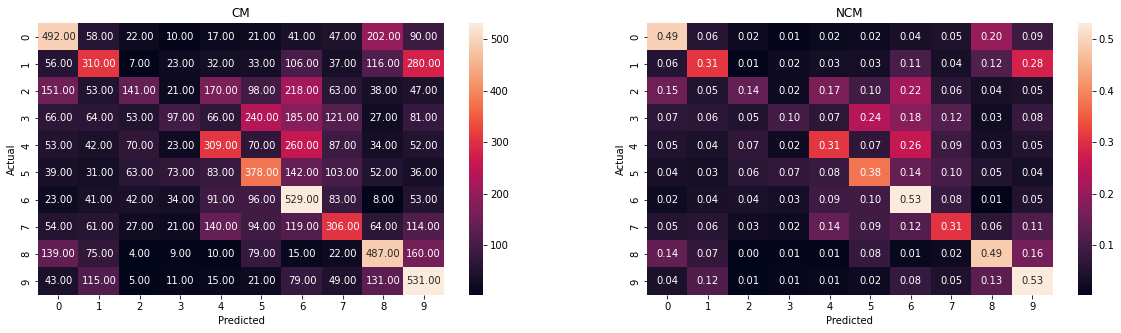

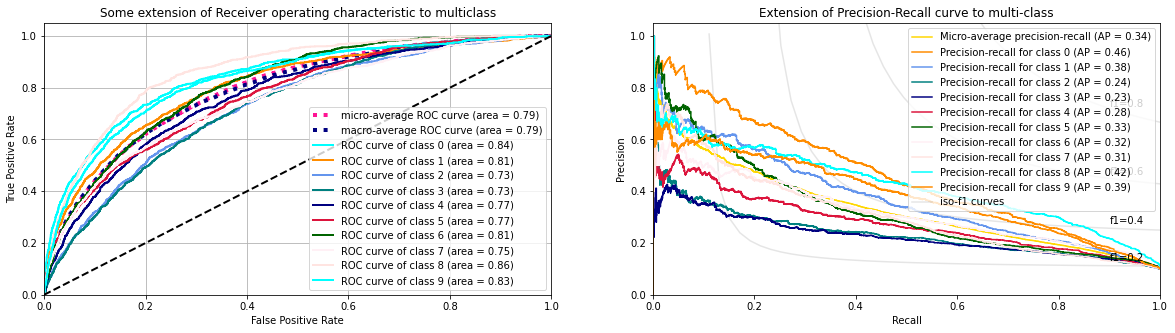

In [159]:
get_report(y_test, y_pred,y_pred_score)

#Test on binary

In [103]:

model=Neural_Network(MLPClassifer(input_dim=2,output_dim=1,hidden_layers=(64,32)))
model.epochs=50
#model.classifier= MLPClassifer(input_dim=X_train.shape[1],output_dim=1)
model.optimiser=Optimiser(name='sgd', classifier=model.classifier, learning_rate=1e-1)
model.loss_function = nn.BCELoss()
model.optimiser,model.epochs

model.fit(X_train, y_train)

model.score(X_test, y_test)
y_pred=model.predict(X_test)
y_pred_score=model.predict_proba(X_test)
model.predict_log_proba(X_train)
model.score_per_class(X_test, y_test)



              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.95      0.86      0.90        21

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



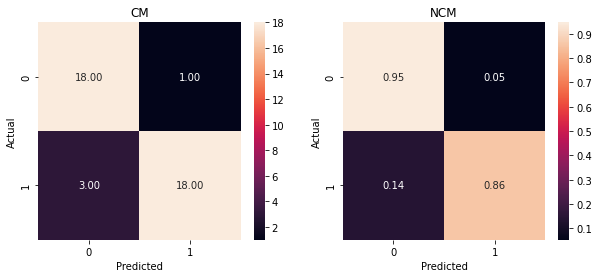

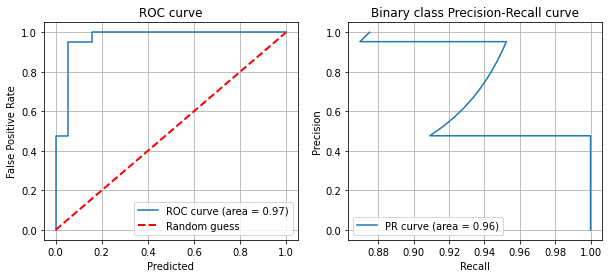

In [107]:
get_report(y_test, y_pred,y_pred_score)

In [ ]:
len(y_pred_score)

40

In [ ]:
len(y_pred)

40

#Plot classifier comparaison



In [ ]:
#initialsise the model for comparasion

model=Neural_Network(MLPClassifer(input_dim=2,output_dim=1))
model.epochs=50
#model.classifier= MLPClassifer(input_dim=X_train.shape[1],output_dim=1)
model.optimiser=Optimiser(name='sgd', classifier=model.classifier, learning_rate=1e-1)
model.loss_function = nn.BCELoss()
model.optimiser,model.epochs
"""
model.fit(X_train, y_train)
model.score(X_test, y_test)
model.predict(X_train)
model.predict_proba(X_train)
model.predict_log_proba(X_train)
print(model.score_per_class(X_test, y_test))
"""

'\nmodel.fit(X_train, y_train)\nmodel.score(X_test, y_test)\nmodel.predict(X_train)\nmodel.predict_proba(X_train)\nmodel.predict_log_proba(X_train)\nprint(model.score_per_class(X_test, y_test))\n'

In [ ]:
#default decision boundary cannot be imported in collab
def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

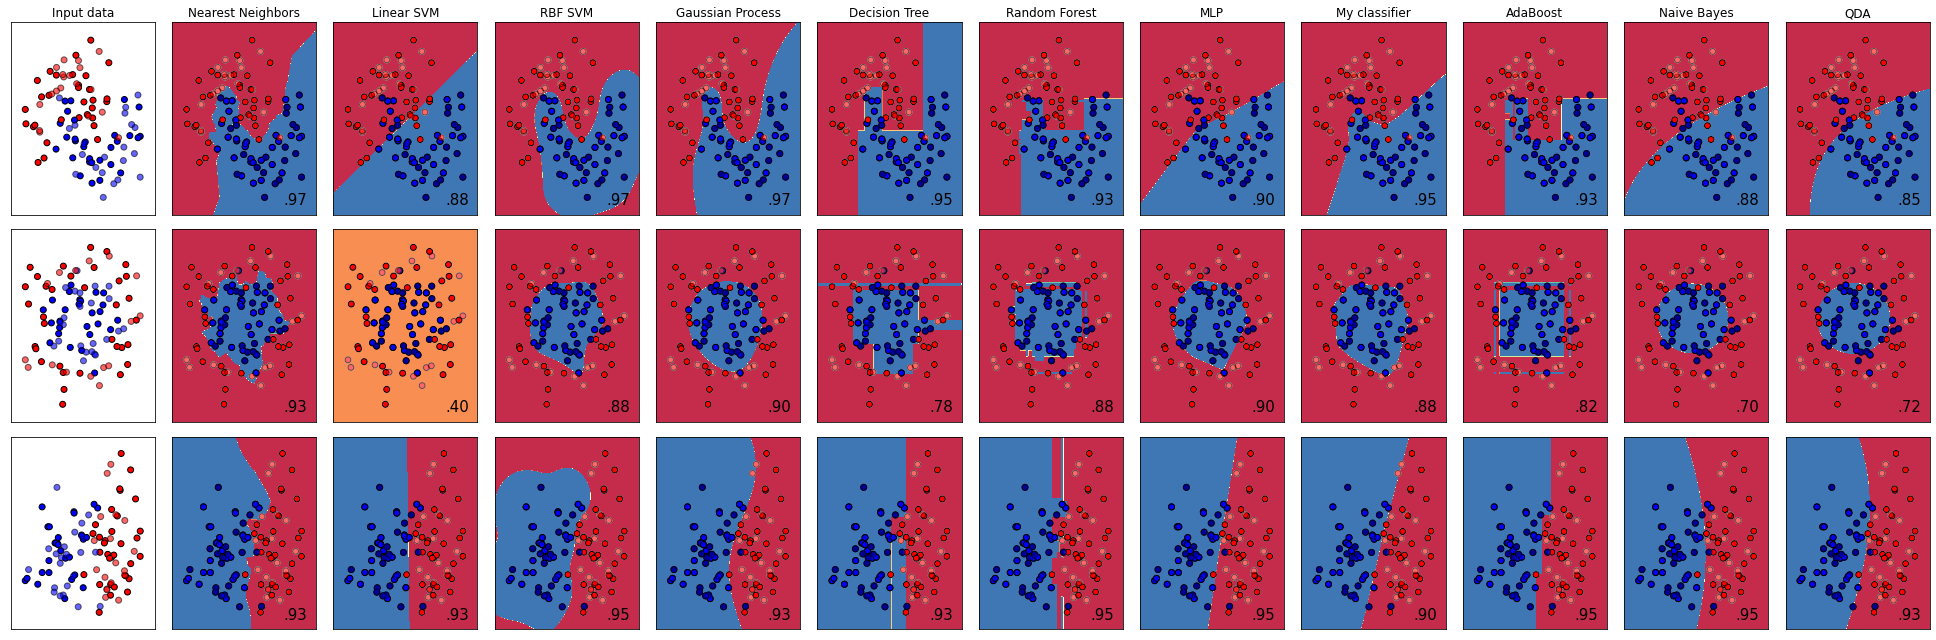

In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "MLP",
    "My classifier",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    model,
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        plot_decision_boundary(clf.predict,X,y)
      

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

# Pipeline

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('mlp', model)])
 # The pipeline can be used as any other estimator
 # and avoids leaking the test set into the train set

pipe.fit(X_train, y_train)

pipe.predict(X_test)
print(pipe.score(X_test, y_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.8


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 # Hyperopt and AutoRank

In [172]:

def objective(params):
    #random.seed(0)
    torch.manual_seed(0)
    epochs=int(params['num_epochs'])
    lr=int(params['learning_rate'])
    layers=int(params['num_h_layers'])
    batch_size=int(params['batch_size'])
    h_dim=32
    model=Neural_Network()
    model.classifier=MLPClassifer(input_dim=2,output_dim=1,dropout=0,hidden_layers=tuple(list(h_dim for i in range(layers))) )
    model.optimiser=Optimiser(name='sgd', classifier=model.classifier, learning_rate=lr)
    model.loss_function = nn.BCELoss()
    model.epochs=epochs
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    pred=model.predict(X_test)
    #model.predict_proba(X_test)
    #model.predict_log_proba(X_test)
    #print(model.score_per_class(X_test, y_test))
    score=mean_squared_error(y_test,pred)
    return score

In [173]:
objective({'num_epochs':10, 'learning_rate':1e-2, 'num_h_layers':1, 'batch_size':1})

0.325

In [174]:
def optimize(trial):
    params={'num_epochs':hp.uniform('num_epochs',1,2),
           'learning_rate':hp.loguniform('learning_rate',1e-4,1e-1),
           'num_h_layers':hp.uniform('num_h_layers',1,7),
           'batch_size':hp.uniform('batch_size',5,20) }


    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=100,rstate=np.random.RandomState(seed))
    return best

In [175]:
trial=Trials()

best=optimize(trial)

100%|██████████| 100/100 [00:26<00:00,  3.78it/s, best loss: 0.175]


In [176]:
len(trial)

100

In [177]:
def decompose_trial_into_relevant_columns_pandas(trials):
    df = pd.DataFrame()
    df['loss']=trials.losses()
    df['learning_rate']=trials.vals['learning_rate']
    df['num_epochs']=[int(a) for a in trials.vals['num_epochs']]
    df['num_h_layers']=[int(a) for a in trials.vals['num_h_layers']]
    df['batch_size']=[int(a) for a in trials.vals['batch_size']]
    return df

In [178]:
df=decompose_trial_into_relevant_columns_pandas(trial)

"""
df=df.transpose()
#df.columns = df.iloc[0]
df = df.reset_index()
#df = df.drop(df.index[0])
df = df.reset_index()
df =df.drop(["level_0","index"],axis = 1)
data=df
"""

'\ndf=df.transpose()\n#df.columns = df.iloc[0]\ndf = df.reset_index()\n#df = df.drop(df.index[0])\ndf = df.reset_index()\ndf =df.drop(["level_0","index"],axis = 1)\ndata=df\n'

In [181]:
df

,loss,learning_rate,num_epochs,num_h_layers,batch_size
0,0.275,1.103580,1,3,7
1,0.525,1.064291,1,4,14
2,0.225,1.095108,1,2,13
3,0.525,1.034889,1,4,7
4,0.175,1.048172,1,1,11
...,...,...,...,...,...
95,0.175,1.005088,1,1,8
96,0.225,1.004611,1,2,7
97,0.525,1.057366,1,4,9
98,0.175,1.015932,1,1,11


In [163]:
result = autorank(data, alpha=0.05, verbose=False)
print(result)

RankResult(rankdf=
    meanrank    median       mad ci_lower ci_upper effect_size   magnitude
71      79.0  1.000000  0.003575    0.175      7.0         0.0  negligible
70      77.6  1.000000  0.020833    0.175      6.0         0.0  negligible
54      77.6  1.000000  0.012185    0.175      7.0         0.0  negligible
95      77.4  1.000000  0.005088    0.175      8.0         0.0  negligible
69      77.4  1.000000  0.022423    0.175      6.0         0.0  negligible
..       ...       ...       ...      ...      ...         ...         ...
63      27.3  1.080662  0.555662    0.525     14.0   -0.138466  negligible
13      27.1  1.095402  0.820402    0.275     18.0   -0.110922  negligible
39      26.6  1.091556  0.816556    0.275     19.0   -0.106951  negligible
36      22.6  1.084354  0.559354    0.525     15.0   -0.143847  negligible
93      18.8  1.088703  0.563703    0.525     18.0   -0.150096  negligible

[100 rows x 7 columns]
pvalue=0.00010513432347069743
cd=78.95399267687603
omnibu

In [183]:
result_bayesian = autorank(df, alpha=0.05, verbose=False, approach='bayesian')
result_bayesian

RankResult(rankdf=                  median       mad  ci_lower  ... p_equal p_smaller decision
batch_size     11.500000       3.5         9  ...     NaN       NaN       NA
num_h_layers    2.000000       1.0         1  ...     0.0       1.0  smaller
learning_rate   1.053468  0.022903  1.035601  ...     0.0       1.0  smaller
num_epochs      1.000000       0.0         1  ...     0.0       1.0  smaller
loss            0.225000      0.05     0.175  ...     0.0       1.0  smaller

[5 rows x 9 columns], pvalue=None, cd=None, omnibus='bayes', posthoc='bayes', all_normal=False, pvals_shapiro=[0.001652075327001512, 1.0, 2.755299766121766e-09, 0.01236982736736536, 5.114961731077228e-13], homoscedastic=None, pval_homogeneity=None, homogeneity_test=None, alpha=0.05, alpha_normality=0.01, num_samples=100, posterior_matrix=              batch_size     num_h_layers    learning_rate       num_epochs  \
batch_size           NaN  (1.0, 0.0, 0.0)  (1.0, 0.0, 0.0)  (1.0, 0.0, 0.0)   
num_h_layers         

In [154]:
create_report(result)


The statistical analysis was conducted for 5 populations with 100 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations loss (p=0.000), num_h_layers (p=0.000), and batch_size (p=0.002). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=0.610 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of

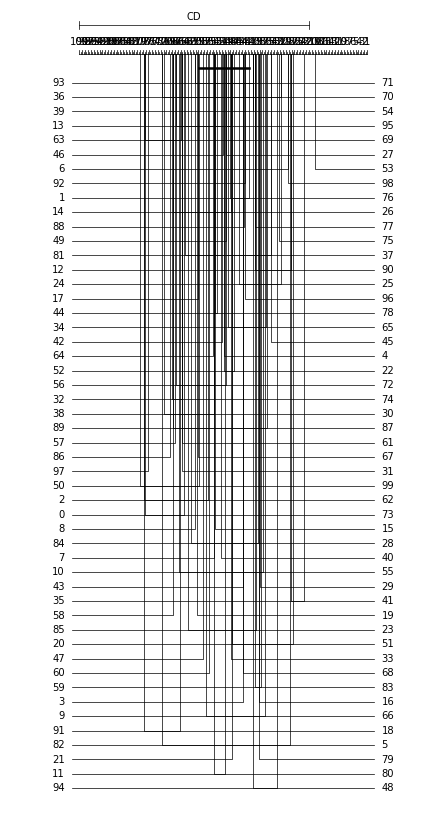

In [164]:
plot_stats(result)
plt.show()

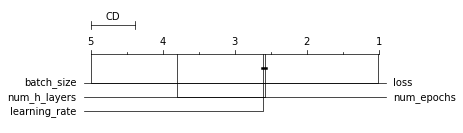

In [133]:
plot_stats(result)
plt.show()